In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import sparse_categorical_crossentropy
import numpy as np

In [2]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
63571,I can't really remember.,Je ne parviens pas vraiment à me souvenir.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
42331,I don't have a badge.,Je n'ai pas de passe.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
12105,Tom got dumped.,Tom s'est fait larguer.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
13812,"Help us, please.","Aide-nous, je te prie !",CC-BY 2.0 (France) Attribution: tatoeba.org #2...
132768,Tom hates it when Mary does that.,Tom déteste quand Mary fait ça.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...


In [3]:
lines = lines[['eng', 'fra']][:33000] # 3.3만개 샘플 사용
lines.sample(5)

,eng,fra
1477,Stop that!,Arrêtez !
19907,Let me handle it.,Laisse-moi m'en charger !
13878,How old are you?,Quel âge avez-vous ?
10815,I was all ears.,J'étais toute ouïe.
26921,Tom waited for me.,Tom m'a attendue.


In [4]:
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
27155,We need to fix it.,On doit corriger ça.
17908,Get into the car.,Rentre dans la voiture.
24199,I love your house.,J'adore votre maison.
16785,We're powerless.,Nous sommes impuissants.
16314,Tom is watching.,Tom regarde.


In [5]:
lines.fra

0                                      Va !
1                                   Marche.
2                                En route !
3                                   Bouge !
4                                   Salut !
                        ...                
32995    Nous avons toutes beaucoup pleuré.
32996                Nous avions tous faim.
32997         Nous avons aussi trouvé ceci.
32998         Nous sommes des gens occupés.
32999         Nous regardons la télévision.
Name: fra, Length: 33000, dtype: object

## 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

In [6]:
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sentence) 
    sentence = sentence.strip() 
    return sentence

import re
def preprocess_sentence2(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sentence) 
    sentence = sentence.strip()
    sentence = "<sos> " + sentence + " <eos>"
    return sentence


In [7]:
line = []

for a in lines.fra:
    preprocessed_sentence = preprocess_sentence2(a)
    line.append(preprocessed_sentence)
line

['<sos> va ! <eos>',
 '<sos> marche . <eos>',
 '<sos> en route ! <eos>',
 '<sos> bouge ! <eos>',
 '<sos> salut ! <eos>',
 '<sos> salut . <eos>',
 '<sos> cours ! <eos>',
 '<sos> courez ! <eos>',
 '<sos> prenez vos jambes vos cous ! <eos>',
 '<sos> file ! <eos>',
 '<sos> filez ! <eos>',
 '<sos> cours ! <eos>',
 '<sos> fuyez ! <eos>',
 '<sos> fuyons ! <eos>',
 '<sos> cours ! <eos>',
 '<sos> courez ! <eos>',
 '<sos> prenez vos jambes vos cous ! <eos>',
 '<sos> file ! <eos>',
 '<sos> filez ! <eos>',
 '<sos> cours ! <eos>',
 '<sos> fuyez ! <eos>',
 '<sos> fuyons ! <eos>',
 '<sos> qui ? <eos>',
 '<sos> a alors ! <eos>',
 '<sos> waouh ! <eos>',
 '<sos> wah ! <eos>',
 '<sos> terre ! <eos>',
 '<sos> baisse toi ! <eos>',
 '<sos> baissez vous ! <eos>',
 '<sos> au feu ! <eos>',
 "<sos> l'aide ! <eos>",
 '<sos> cache toi . <eos>',
 '<sos> cachez vous . <eos>',
 '<sos> saute . <eos>',
 '<sos> saute . <eos>',
 '<sos> a suffit ! <eos>',
 '<sos> stop ! <eos>',
 '<sos> arr te toi ! <eos>',
 '<sos> attend

In [8]:
line2 = []

for a in lines.eng:
    preprocessed_sentence = preprocess_sentence(a)
    line2.append(preprocessed_sentence)
line2

['go .',
 'go .',
 'go .',
 'go .',
 'hi .',
 'hi .',
 'run !',
 'run !',
 'run !',
 'run !',
 'run !',
 'run !',
 'run !',
 'run !',
 'run .',
 'run .',
 'run .',
 'run .',
 'run .',
 'run .',
 'run .',
 'run .',
 'who ?',
 'wow !',
 'wow !',
 'wow !',
 'duck !',
 'duck !',
 'duck !',
 'fire !',
 'help !',
 'hide .',
 'hide .',
 'jump !',
 'jump .',
 'stop !',
 'stop !',
 'stop !',
 'wait !',
 'wait !',
 'wait !',
 'wait .',
 'wait .',
 'wait .',
 'wait .',
 'begin .',
 'begin .',
 'go on .',
 'go on .',
 'go on .',
 'hello !',
 'hello !',
 'i see .',
 'i see .',
 'i try .',
 'i won !',
 'i won !',
 'i won .',
 'oh no !',
 'relax .',
 'relax .',
 'relax .',
 'relax .',
 'relax .',
 'relax .',
 'relax .',
 'relax .',
 'relax .',
 'relax .',
 'relax .',
 'relax .',
 'smile .',
 'smile .',
 'smile .',
 'sorry ?',
 'attack !',
 'attack !',
 'attack !',
 'attack !',
 'buy it .',
 'buy it .',
 'buy it .',
 'buy it .',
 'cheers !',
 'cheers !',
 'cheers !',
 'cheers !',
 'eat it .',
 'eat it

In [9]:
line[0]

'<sos> va ! <eos>'

## 케라스의 토크나이저로 텍스트를 숫자로 바꾸기

In [10]:
eng_tokenizer = Tokenizer(char_level=False, filters = '')   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(line2)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(line2)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:10]

[[25, 1],
 [25, 1],
 [25, 1],
 [25, 1],
 [782, 1],
 [782, 1],
 [207, 20],
 [207, 20],
 [207, 20],
 [207, 20]]

In [11]:
fra_tokenizer = Tokenizer(char_level=False, filters = '')  #char_level=False, # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(line)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(line)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:10]

[[1, 70, 7, 2],
 [1, 384, 3, 2],
 [1, 26, 541, 7, 2],
 [1, 754, 7, 2],
 [1, 789, 7, 2],
 [1, 789, 3, 2],
 [1, 694, 7, 2],
 [1, 1953, 7, 2],
 [1, 194, 282, 1097, 282, 2727, 7, 2],
 [1, 1541, 7, 2]]

In [12]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4771
프랑스어 단어장의 크기 : 7972


In [13]:
eng_tokenizer.word_index

{'.': 1,
 'i': 2,
 '?': 3,
 'you': 4,
 'tom': 5,
 'is': 6,
 'a': 7,
 'it': 8,
 "i'm": 9,
 'the': 10,
 'was': 11,
 'me': 12,
 "you're": 13,
 'this': 14,
 'he': 15,
 'are': 16,
 'to': 17,
 'that': 18,
 'we': 19,
 '!': 20,
 'do': 21,
 "it's": 22,
 'my': 23,
 'your': 24,
 'go': 25,
 'have': 26,
 'not': 27,
 "don't": 28,
 'they': 29,
 'be': 30,
 'no': 31,
 "we're": 32,
 'can': 33,
 'did': 34,
 'she': 35,
 'all': 36,
 'like': 37,
 'here': 38,
 'in': 39,
 'get': 40,
 "that's": 41,
 'up': 42,
 "i'll": 43,
 'very': 44,
 'on': 45,
 'what': 46,
 'need': 47,
 'how': 48,
 'want': 49,
 "they're": 50,
 'one': 51,
 ',': 52,
 'him': 53,
 'out': 54,
 'love': 55,
 'come': 56,
 'please': 57,
 "can't": 58,
 'us': 59,
 'just': 60,
 'know': 61,
 'now': 62,
 'stop': 63,
 'so': 64,
 'of': 65,
 "let's": 66,
 'got': 67,
 'too': 68,
 'help': 69,
 "he's": 70,
 'look': 71,
 'take': 72,
 'let': 73,
 'good': 74,
 'for': 75,
 'who': 76,
 'has': 77,
 'there': 78,
 'at': 79,
 'see': 80,
 'will': 81,
 'were': 82,
 'keep'

In [14]:
fra_tokenizer.word_index

{'<sos>': 1,
 '<eos>': 2,
 '.': 3,
 'je': 4,
 '?': 5,
 'tom': 6,
 '!': 7,
 'est': 8,
 'vous': 9,
 'pas': 10,
 'a': 11,
 'il': 12,
 'le': 13,
 'de': 14,
 'nous': 15,
 'ne': 16,
 'suis': 17,
 'tu': 18,
 "c'est": 19,
 'la': 20,
 "j'ai": 21,
 'ce': 22,
 'un': 23,
 't': 24,
 'me': 25,
 'en': 26,
 'tes': 27,
 'd': 28,
 's': 29,
 'es': 30,
 'que': 31,
 'les': 32,
 'une': 33,
 'e': 34,
 'moi': 35,
 'te': 36,
 'elle': 37,
 ',': 38,
 'tait': 39,
 'sont': 40,
 'ils': 41,
 'sommes': 42,
 'fait': 43,
 'r': 44,
 'tout': 45,
 'l': 46,
 'elles': 47,
 'qui': 48,
 'des': 49,
 "n'est": 50,
 'mon': 51,
 're': 52,
 'toi': 53,
 'bien': 54,
 'y': 55,
 'ai': 56,
 'tr': 57,
 'pr': 58,
 'se': 59,
 'ici': 60,
 'du': 61,
 'besoin': 62,
 'faire': 63,
 "l'air": 64,
 'peux': 65,
 'on': 66,
 'cela': 67,
 'personne': 68,
 'arr': 69,
 'va': 70,
 'm': 71,
 'veux': 72,
 'votre': 73,
 'as': 74,
 'tais': 75,
 'fais': 76,
 "j'aime": 77,
 'tre': 78,
 'ma': 79,
 "s'est": 80,
 'ton': 81,
 'faut': 82,
 'avez': 83,
 'avons': 84,

In [15]:
# 훈련 후 결과 비교할때 사용
src_to_index= eng_tokenizer.word_index
index_to_src= eng_tokenizer.index_word
# 훈련 후 예측 과정에서 사용
# 훈련 후 결과 비교할 때 사용
tar_to_index= fra_tokenizer.word_index
index_to_tar= fra_tokenizer.index_word


In [16]:
max_eng_seq_len = max([len(line2) for line2 in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


In [18]:
fra_tokenizer.word_index

{'<sos>': 1,
 '<eos>': 2,
 '.': 3,
 'je': 4,
 '?': 5,
 'tom': 6,
 '!': 7,
 'est': 8,
 'vous': 9,
 'pas': 10,
 'a': 11,
 'il': 12,
 'le': 13,
 'de': 14,
 'nous': 15,
 'ne': 16,
 'suis': 17,
 'tu': 18,
 "c'est": 19,
 'la': 20,
 "j'ai": 21,
 'ce': 22,
 'un': 23,
 't': 24,
 'me': 25,
 'en': 26,
 'tes': 27,
 'd': 28,
 's': 29,
 'es': 30,
 'que': 31,
 'les': 32,
 'une': 33,
 'e': 34,
 'moi': 35,
 'te': 36,
 'elle': 37,
 ',': 38,
 'tait': 39,
 'sont': 40,
 'ils': 41,
 'sommes': 42,
 'fait': 43,
 'r': 44,
 'tout': 45,
 'l': 46,
 'elles': 47,
 'qui': 48,
 'des': 49,
 "n'est": 50,
 'mon': 51,
 're': 52,
 'toi': 53,
 'bien': 54,
 'y': 55,
 'ai': 56,
 'tr': 57,
 'pr': 58,
 'se': 59,
 'ici': 60,
 'du': 61,
 'besoin': 62,
 'faire': 63,
 "l'air": 64,
 'peux': 65,
 'on': 66,
 'cela': 67,
 'personne': 68,
 'arr': 69,
 'va': 70,
 'm': 71,
 'veux': 72,
 'votre': 73,
 'as': 74,
 'tais': 75,
 'fais': 76,
 "j'aime": 77,
 'tre': 78,
 'ma': 79,
 "s'est": 80,
 'ton': 81,
 'faut': 82,
 'avez': 83,
 'avons': 84,

## 디코더의 문장에 시작 토큰과 종료 토큰을 넣고, 종료 토큰, 시작 토큰 제거

In [21]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index['<eos>'] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index['<sos>'] ] for line in target_text]

In [23]:
target_text

[[1, 70, 7, 2],
 [1, 384, 3, 2],
 [1, 26, 541, 7, 2],
 [1, 754, 7, 2],
 [1, 789, 7, 2],
 [1, 789, 3, 2],
 [1, 694, 7, 2],
 [1, 1953, 7, 2],
 [1, 194, 282, 1097, 282, 2727, 7, 2],
 [1, 1541, 7, 2],
 [1, 2284, 7, 2],
 [1, 694, 7, 2],
 [1, 2728, 7, 2],
 [1, 3460, 7, 2],
 [1, 694, 7, 2],
 [1, 1953, 7, 2],
 [1, 194, 282, 1097, 282, 2727, 7, 2],
 [1, 1541, 7, 2],
 [1, 2284, 7, 2],
 [1, 694, 7, 2],
 [1, 2728, 7, 2],
 [1, 3460, 7, 2],
 [1, 48, 5, 2],
 [1, 11, 945, 7, 2],
 [1, 4840, 7, 2],
 [1, 4841, 7, 2],
 [1, 640, 7, 2],
 [1, 1385, 53, 7, 2],
 [1, 3461, 9, 7, 2],
 [1, 92, 517, 7, 2],
 [1, 412, 7, 2],
 [1, 1728, 53, 3, 2],
 [1, 4842, 9, 3, 2],
 [1, 1542, 3, 2],
 [1, 1542, 3, 2],
 [1, 11, 623, 7, 2],
 [1, 3462, 7, 2],
 [1, 69, 36, 53, 7, 2],
 [1, 448, 7, 2],
 [1, 487, 7, 2],
 [1, 487, 3, 2],
 [1, 448, 7, 2],
 [1, 487, 7, 2],
 [1, 448, 3, 2],
 [1, 487, 3, 2],
 [1, 1179, 3, 2],
 [1, 755, 3, 2],
 [1, 1729, 3, 2],
 [1, 402, 3, 2],
 [1, 2729, 3, 2],
 [1, 712, 7, 2],
 [1, 789, 7, 2],
 [1, 4, 713, 3,

In [24]:
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_target[:3])

[[25, 1], [25, 1], [25, 1]]
[[1, 70, 7], [1, 384, 3], [1, 26, 541, 7]]
[[70, 7, 2], [384, 3, 2], [26, 541, 7, 2]]


In [25]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


In [26]:
print(encoder_input[0])

[25  1  0  0  0  0  0  0]


In [27]:
encoder_input[0]

array([25,  1,  0,  0,  0,  0,  0,  0], dtype=int32)

In [28]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (30000, 8)
훈련 target 데이터의 크기 : (30000, 16)
훈련 target 레이블의 크기 : (30000, 16)
테스트 source 데이터의 크기 : (3000, 8)
테스트 target 데이터의 크기 : (3000, 16)
테스트 target 레이블의 크기 : (3000, 16)


## 임베딩 층(Embedding layer) 사용하기

In [29]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [30]:
latent_dim = 64

In [31]:
# 인코더
# 입력 텐서 생성.
encoder_inputs = Input(shape=(None,))
# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_emb = Embedding(eng_vocab_size, latent_dim)(encoder_inputs)
encoder_masking =Masking(mask_value=0.0)(encoder_emb)
encoder_lstm = LSTM(latent_dim, return_state = True)
# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_masking)
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

In [32]:
# 디코더
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None,))
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_emb_layer = Embedding(fra_vocab_size, latent_dim)
decoder_emb = decoder_emb_layer(decoder_inputs)
decoder_masking =Masking(mask_value=0.0)(decoder_emb)

decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_masking, initial_state = encoder_states)

In [33]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

## 모델 구현

In [34]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     305344      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     510208      input_2[0][0]                    
______________________________________________________________________________________________

In [35]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 16s 34ms/step - loss: 2.7633 - acc: 0.6486 - val_loss: 2.0594 - val_acc: 0.7032
Epoch 2/50
235/235 [==============================] - 6s 25ms/step - loss: 1.6185 - acc: 0.7506 - val_loss: 1.8698 - val_acc: 0.7257
Epoch 3/50
235/235 [==============================] - 6s 25ms/step - loss: 1.4847 - acc: 0.7632 - val_loss: 1.7729 - val_acc: 0.7370
Epoch 4/50
235/235 [==============================] - 6s 25ms/step - loss: 1.3721 - acc: 0.7797 - val_loss: 1.7009 - val_acc: 0.7456
Epoch 5/50
235/235 [==============================] - 6s 25ms/step - loss: 1.2874 - acc: 0.7934 - val_loss: 1.6439 - val_acc: 0.7507
Epoch 6/50
235/235 [==============================] - 6s 25ms/step - loss: 1.2211 - acc: 0.8042 - val_loss: 1.5799 - val_acc: 0.7630
Epoch 7/50
235/235 [==============================] - 6s 25ms/step - loss: 1.1685 - acc: 0.8123 - val_loss: 1.5386 - val_acc: 0.7707
Epoch 8/50
235/235 [==============================] - 6s 25ms/step -

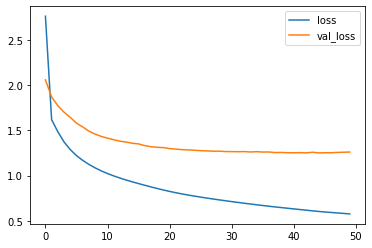

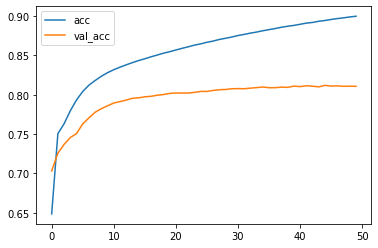

In [36]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
history_df['loss'].plot()
history_df['val_loss'].plot()
plt.legend()
plt.show()


history_df = pd.DataFrame(history.history)
history_df['acc'].plot()
history_df['val_acc'].plot()
plt.legend()
plt.show()

## 모델 평가하기

In [37]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)
# 디코더
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_inputs = [decoder_state_input_h,decoder_state_input_c]

dec_emb2 = decoder_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state= decoder_state_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [38]:
# 디코더 정의
decoder_model = Model([decoder_inputs]+decoder_state_inputs,[decoder_outputs2]+decoder_states2)

In [39]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <sos>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = tar_to_index['<sos>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [40]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp=temp+index_to_src[i]+ ' '
    return temp
# 변역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i != tar_to_index['<sos>']) and i != tar_to_index['<eos>']):
            temp=temp+index_to_tar[i]+ ' '
    return temp

In [41]:
import numpy as np
for seq_index in  [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_train[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_train[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:-5])

-----------------------------------
입력 문장: go . 
정답 문장: bouge ! 
번역기가 번역한 문장:  va le ! 
-----------------------------------
입력 문장: hello ! 
정답 문장: bonjour ! 
번역기가 번역한 문장:  ! toi les n'a
-----------------------------------
입력 문장: got it ? 
정답 문장: t'as capt ? 
번역기가 번역한 문장:  quoi ? 
-----------------------------------
입력 문장: hang on . 
정답 문장: tiens bon ! 
번역기가 번역한 문장:  tiens bien . 
-----------------------------------
입력 문장: here's . 
정답 문장: voil cinq dollars . 
번역기가 번역한 문장:  voici du caf . 


In [42]:
for seq_index in  [1, 250, 431, 105,322]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:-5])

-----------------------------------
입력 문장: i lost your number . 
정답 문장: j'ai perdu votre num ro . 
번역기가 번역한 문장:  je me suis 
-----------------------------------
입력 문장: i think you did it . 
정답 문장: je pense que c'est toi qui l'a fait . 
번역기가 번역한 문장:  je pense que a
-----------------------------------
입력 문장: i won't say a word . 
정답 문장: je ne dirai pas un mot . 
번역기가 번역한 문장:  je ne peux pas m
-----------------------------------
입력 문장: i never was skinny . 
정답 문장: je n'ai jamais t maigre . 
번역기가 번역한 문장:  je ne devrai
-----------------------------------
입력 문장: i want to tell you . 
정답 문장: je veux vous le dire . 
번역기가 번역한 문장:  je veux le me


-----------------------------------
입력 문장: i lost your number . -> 나는 너의 번호를 잃어버렸다.

정답 문장: j'ai perdu votre num ro . -> 나는 너의 번호를 잃어버렸다.

번역기가 번역한 문장:  je me suis -> 나 자신을 따라가고 있어.

-----------------------------------
입력 문장: i think you did it . -> 네가 해낸 것 같아.

정답 문장: je pense que c'est toi qui l'a fait . -> 네가 해낸 것 같아.

번역기가 번역한 문장:  je pense que a -> 난 그게…...

-----------------------------------
입력 문장: i won't say a word . -> 난 한 마디도 안 할 것이다.

정답 문장: je ne dirai pas un mot .  -> 난 한 마디도 안 할 것이다.

번역기가 번역한 문장:  je ne peux pas m -> 못해요.

----------------------------------- 
입력 문장: i never was skinny . -> 나는 결코 말랐던 적이 없다.

정답 문장: je n'ai jamais t maigre . -> 나는 결코 말랐던 적이 없다.

번역기가 번역한 문장:  je ne devrai -> 나는 그럼 안돼.

-----------------------------------
입력 문장: i want to tell you . -> 나는 너에게 말하고 싶다.

정답 문장: je veux vous le dire . -> 나는 너에게 말하고 싶다.

번역기가 번역한 문장:  je veux le me -> 저 그걸 갖고 싶어요.

## 회고
- 어려웠던 점 : encoder와 decoder을 구분해서 model을 구현하는게 어려웠다.
- 알아낸 점 및 모호한 점 : 마지막 출력 시킬때, encoder_input과 decoder_input을 잘 구분해서 적어야하는 것을 알게 되었다.
- 노력한 점 : val_loss가 우하향하는 모습을 보도록 그래프를 그렸다.
- 자기다짐 : 번역기를 또 한글로 바꾸는 점이 힘들었지만, 완성도 있는 번역기를 확인 할 수 있어서 좋았다.